In [1]:
from tools import *
import matplotlib.pyplot as plt
import tools
import ms
import os
import numpy as np
import torch
import re
from tqdm import tqdm
from importlib import reload
import bio_helper
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2
reload(bio_helper)

plt.style.use(['science', "ieee", 'high-vis', 'no-latex'])


mass mass vs raw mass 
msms inensity vs raw intensity


matched ions mass: mass vs raw


In [2]:

def to_tensor(frag_msms):
    frag_msms = [i.reshape(1, -1) for i in frag_msms]
    frag_msms = np.concatenate(frag_msms, axis=0)
    frag_msms /= frag_msms.max()
    return torch.from_numpy(frag_msms)
# name, msms_data = read_msms(
#     "/data/prosit/test/fig3a/pick_msms.txt")


def read_ions(msms, name):
    i_index = name.index("Intensities")
    m_index = name.index("Matches")
    mass_index = name.index("Masses")
    return [(i[m_index].split(";"), i[i_index].split(";"), i[mass_index].split(";")) for i in msms]

from importlib import reload
reload(ms)


def generate_from_msms(msms_data, nces=range(20, 40)):
    seqs = [i[name.index("Modified sequence")].strip("_") for i in msms_data]
    seqs = [bio_helper.peptide_to_inter(i) for i in seqs]
    seqs = np.concatenate(seqs)

    charges = [int(i[name.index("Charge")]) for i in msms_data]
    charges = [bio_helper.one_hot(i-1) for i in charges]
    charges = np.concatenate(charges)

    data_nce_cand = {}
    for nce in nces:
        data_nce_cand[nce] = [
            seqs,
            np.ones((len(seqs), ), dtype=int)*nce/100.0,
            charges
        ]
    return data_nce_cand

def get_nce_all(run_model, data_nce_cand, gt_frag):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    def perpare_data(seqs, nces, charges):
        seqs = torch.from_numpy(seqs)
        nces = torch.from_numpy(nces).unsqueeze(1)
        charges = torch.from_numpy(charges)
        data = {}
        data["sequence_integer"] = seqs.to(device)
        data["collision_energy_aligned_normed"] = nces.to(device)
        data['precursor_charge_onehot'] = charges.to(device)
        data['peptide_mask'] = ms.helper.create_mask(seqs).to(device)
        return data

    all_sa = {}
    run_model = run_model.to(device)
    gt_frag = gt_frag.to(device)
    gt_frag = gt_frag/gt_frag.max()
    with torch.no_grad():
        for nce_name, nce_data in tqdm(data_nce_cand.items()):
            data = perpare_data(*nce_data)
            sass = []
            for b in range(0, len(gt_frag), 2048):
                d = {k : v[b:b+2048] for k,v in data.items()}
                pred = run_model(d)
                sas = helper.predict_sa(gt_frag[b:b+2048], pred, d)
                # sas = helper.spectral_angle(gt_frag[b:b+2048], pred)
                sass.append(sas)
            all_sa[nce_name] = torch.cat(sass, dim=0)
    return all_sa
    

def get_nce_cal(run_model, data_nce_cand, gt_frag):
    all_sa = get_nce_all(run_model, data_nce_cand, gt_frag)
    all_sa = {k:torch.median(v) for k, v in all_sa.items()}
    return all_sa


In [3]:

data2plot = {}

In [5]:
from ms import model
import ms

# run_model = model.TransProBest()
# run_model.load_state_dict(torch.load(
#     "../checkpoints/best/best_valid_frag_TransPro-6-3-128-0.1-256-1048.pth", map_location="cpu"))
# trans_model = run_model.eval()

# run_model = model.PrositFrag()
# run_model.load_state_dict(torch.load(
#     "../checkpoints/frag/best_nce_frag_PrositFrag-512.pth", map_location="cpu"))

run_model = model.TransPro()
run_model.load_state_dict(torch.load(
    "../checkpoints/frag/nce/best_nce_frag_TransPro-cls-6-3-128-0.1-256-512-0.1-0.3.pth", map_location="cpu"))

# run_model.load_state_dict(torch.load(
#     "../checkpoints/best/best_valid_irt_PrositFrag-1024.pth", map_location="cpu"))
prosit = run_model.eval()


In [6]:
test_model_frag(prosit)

Got 754215 sequences
Load Train: 754215


737it [01:56,  6.33it/s]

----Test Loss: 0.15505----


In [7]:
from ms import model
import ms

for read_part in ["trypsin"]:#, 'gluc', 'lysc', 'chymo']:
    print(read_part)
    name, msms_data = tools.read_msms(
        f"/data/prosit/figs/fig235/{read_part}/maxquant/combined/txt/msms.txt")
    msms_data = tools.filter_msms(name, msms_data)
    print(len(msms_data))
    msms_data.sort(key=lambda x: -float(x[name.index("Score")]))
    
    # new_msms = []
    # for i in range(0, len(msms_data), 100000):
    #     new_msms.extend(msms_data[i:i+1000])
    # msms_data = new_msms
    msms_data = msms_data[:1000]
    msms_data.sort(key=lambda x: int(x[name.index("id")]))

    m_r = loc_msms_in_raw(msms_data, f"/data/prosit/figs/fig235/{read_part}/raw")
    m_r = sorted(m_r, key=lambda x: int(x[0][name.index("id")]))

    matched_ions_pre = generate_matched_ions(m_r)
    m_i = [bio_helper.match_all(i, 'yb') for i in matched_ions_pre]
    frag_msms = [bio_helper.reverse_annotation(*i[:4]) for i in m_i]
    gt_frag = to_tensor(frag_msms)

    data_nce_cand = generate_from_msms(msms_data)

    # ########################
    # trans_sa = get_nce_cal(trans_model, data_nce_cand, gt_frag)
    prosit_sa = get_nce_cal(prosit, data_nce_cand, gt_frag)

    data2plot[read_part] = (prosit_sa, 0)


trypsin
663031


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


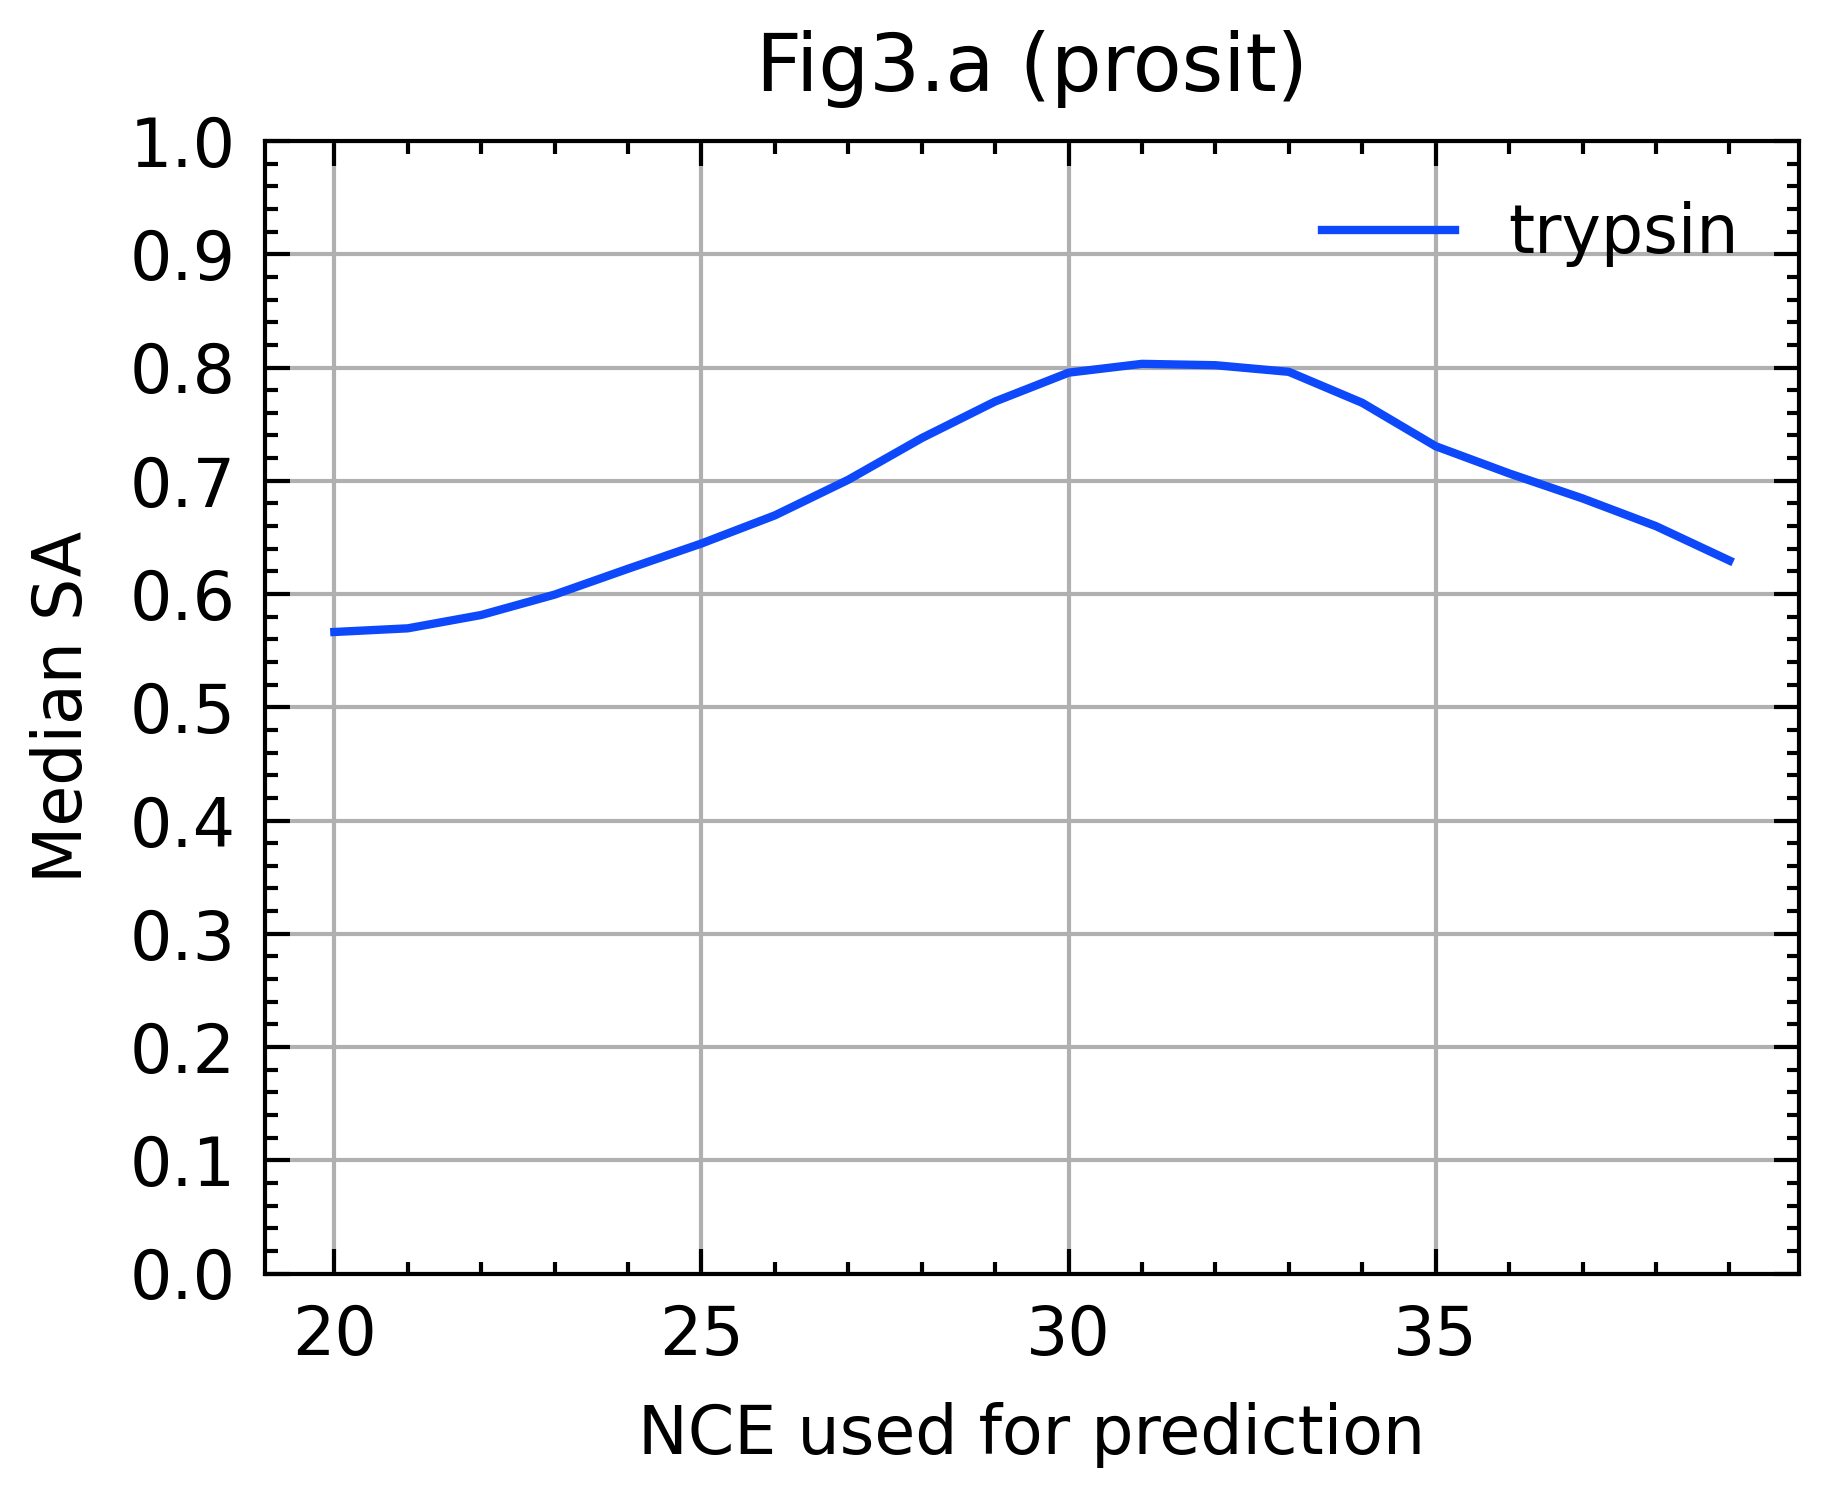

In [8]:
for name, p in data2plot.items():
    keys = sorted(list(p[0].keys()))
    plt.plot(keys, [p[0][k] for k in keys], label=name)
plt.xlabel("NCE used for prediction")
plt.ylabel("Median SA")
plt.title("Fig3.a (prosit)")
plt.yticks([0.1*i for i in range(0, 11)])
plt.grid()
plt.legend()


In [33]:
data2plot['trypsin']

({20: tensor(0.0015, device='cuda:0', dtype=torch.float64),
  21: tensor(0.0016, device='cuda:0', dtype=torch.float64),
  22: tensor(0.0016, device='cuda:0', dtype=torch.float64),
  23: tensor(0.0017, device='cuda:0', dtype=torch.float64),
  24: tensor(0.0018, device='cuda:0', dtype=torch.float64),
  25: tensor(0.0019, device='cuda:0', dtype=torch.float64),
  26: tensor(0.0020, device='cuda:0', dtype=torch.float64),
  27: tensor(0.0022, device='cuda:0', dtype=torch.float64),
  28: tensor(0.0022, device='cuda:0', dtype=torch.float64),
  29: tensor(0.0024, device='cuda:0', dtype=torch.float64),
  30: tensor(0.0026, device='cuda:0', dtype=torch.float64),
  31: tensor(0.0027, device='cuda:0', dtype=torch.float64),
  32: tensor(0.0028, device='cuda:0', dtype=torch.float64),
  33: tensor(0.0029, device='cuda:0', dtype=torch.float64),
  34: tensor(0.0029, device='cuda:0', dtype=torch.float64),
  35: tensor(0.0029, device='cuda:0', dtype=torch.float64),
  36: tensor(0.0029, device='cuda:0', dt

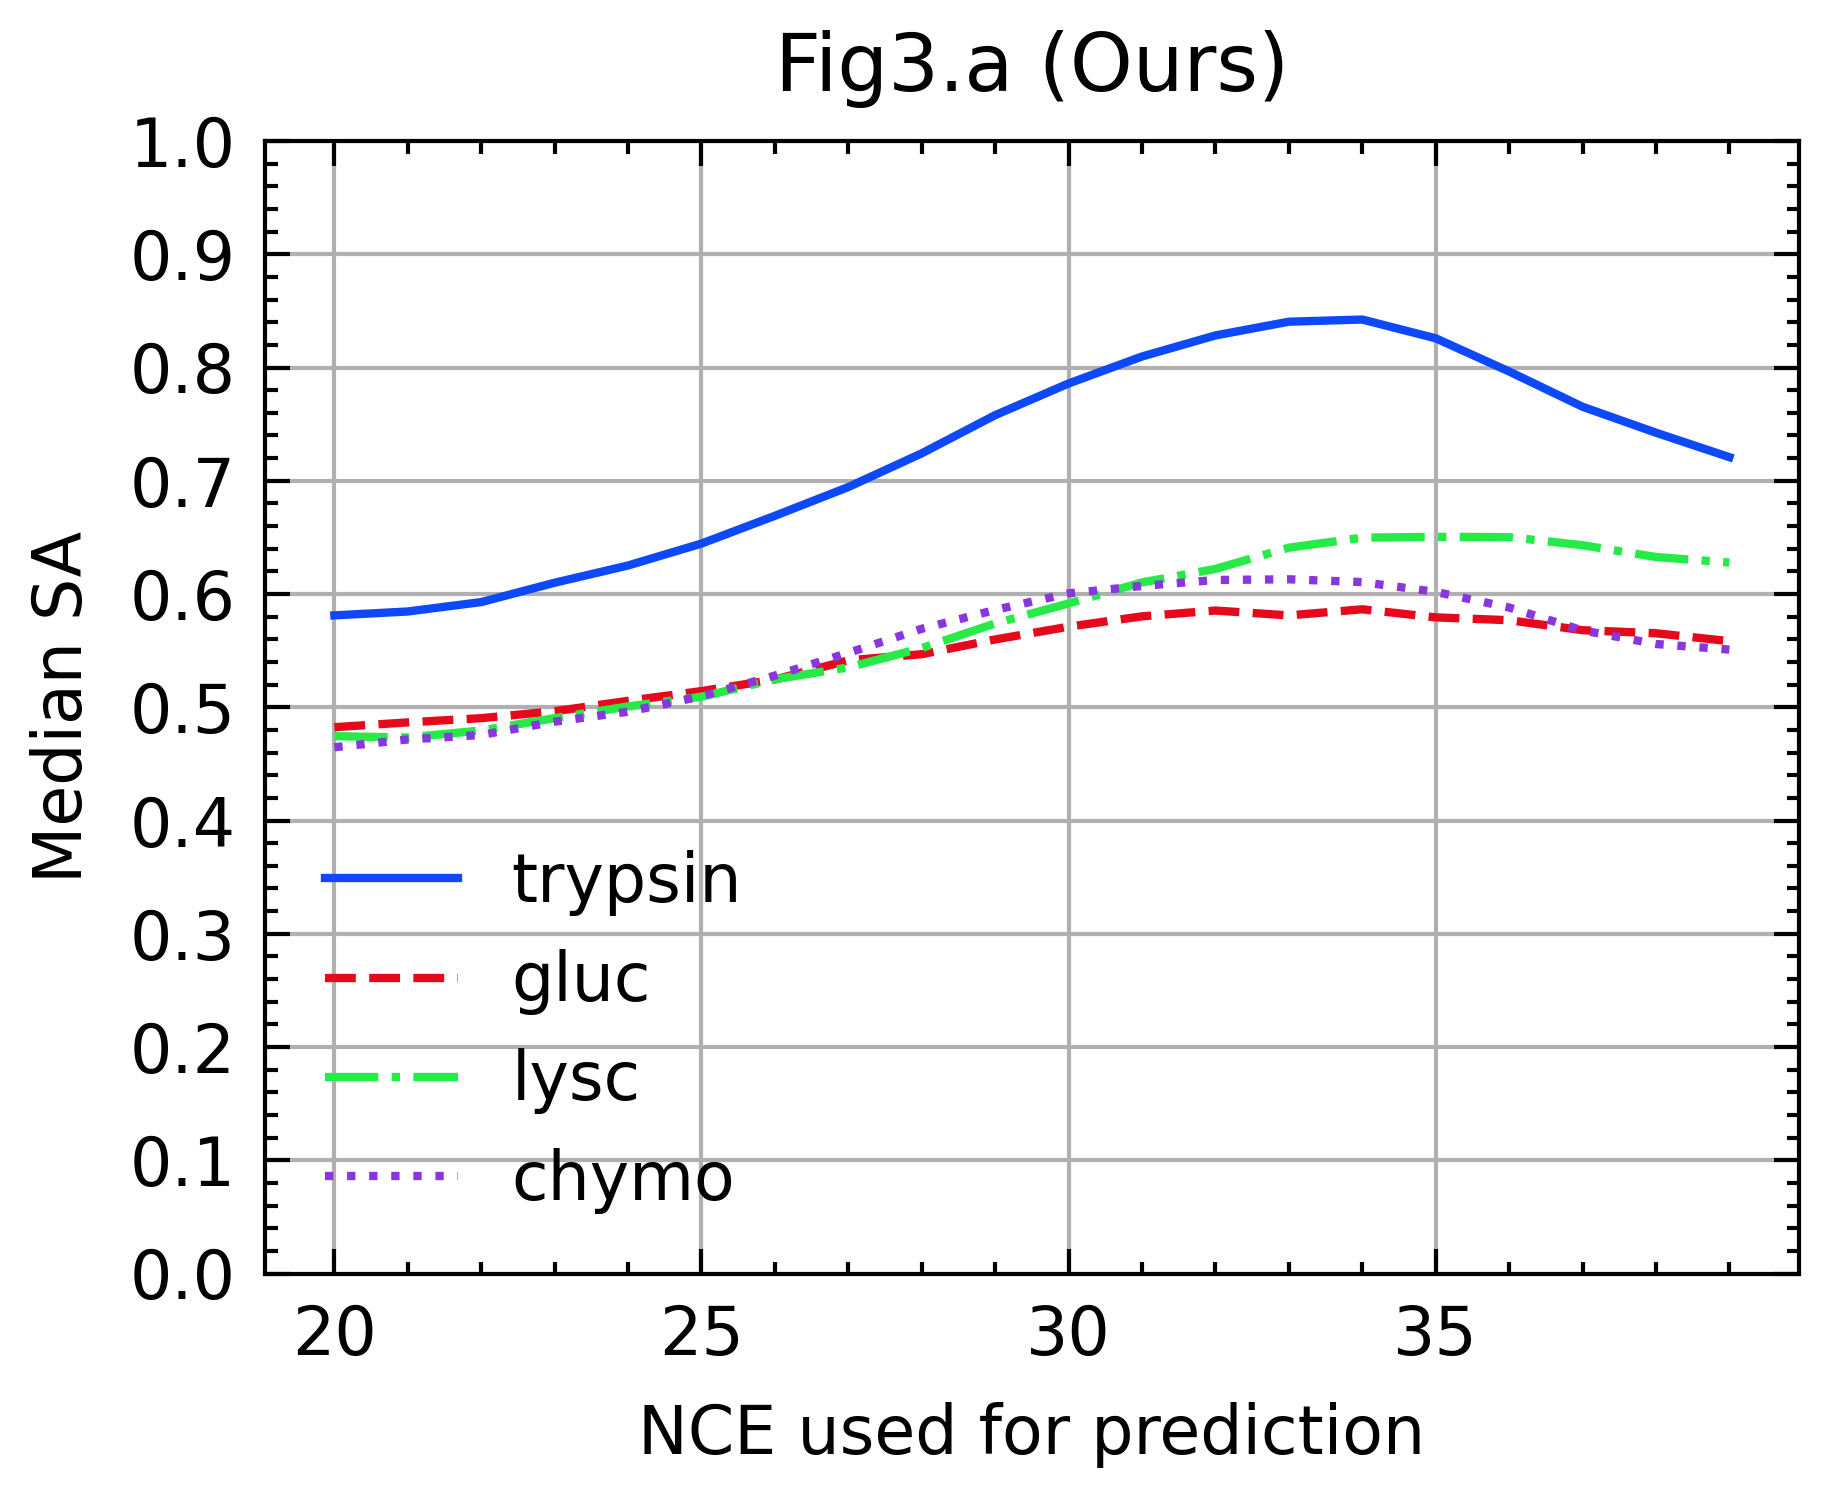

In [18]:
for name, p in data2plot.items():
    keys = sorted(list(p[1].keys()))
    plt.plot(keys, [p[1][k] for k in keys], label=name)
plt.xlabel("NCE used for prediction")
plt.ylabel("Median SA")
plt.title("Fig3.a (Ours)")
plt.yticks([0.1*i for i in range(0, 11)])
plt.grid()
plt.legend()


In [4]:
from ms import model
import ms
add_steps = {}

read_part = "trypsin"
name, msms_data = tools.read_msms(
    f"/data/prosit/figs/fig235/{read_part}/maxquant/combined/txt/msms.txt")
ori_msms_data = tools.filter_msms(name, msms_data)
ori_msms_data.sort(key=lambda x: -float(x[name.index("Score")]))

for read_part_i in range(350000, 400001, 5000):
    # new_msms = []
    # for i in range(0, len(msms_data), 100000):
    #     new_msms.extend(msms_data[i:i+1000])
    # msms_data = new_msms
    msms_data = ori_msms_data[read_part_i:read_part_i + 1000]
    msms_data.sort(key=lambda x: int(x[name.index("id")]))

    m_r = loc_msms_in_raw(msms_data, f"/data/prosit/figs/fig235/{read_part}/raw")
    m_r = sorted(m_r, key=lambda x: int(x[0][name.index("id")]))
    print(len(m_r))

    matched_ions_pre = generate_matched_ions(m_r)
    m_i = [bio_helper.match_all(i, 'yb') for i in matched_ions_pre]
    frag_msms = [bio_helper.reverse_annotation(*i[:2]) for i in m_i]
    gt_frag = to_tensor(frag_msms)

    data_nce_cand = generate_from_msms(msms_data)

    # ########################
    trans_sa = get_nce_cal(trans_model, data_nce_cand, gt_frag)
    prosit_sa = get_nce_cal(prosit, data_nce_cand, gt_frag)

    add_steps[read_part_i] = (prosit_sa, trans_sa)


1000


NameError: name 'to_tensor' is not defined

In [2]:
for name, p in add_steps.items():
    keys = sorted(list(p[0].keys()))
    plt.plot(keys, [p[0][k] for k in keys], label=name)
plt.xlabel("NCE used for prediction")
plt.ylabel("Median SA")
plt.title(f"Fig3.a (prosit) - {read_part}")
plt.yticks([0.1*i for i in range(0, 11)])
plt.grid()
# plt.legend()


NameError: name 'add_steps' is not defined

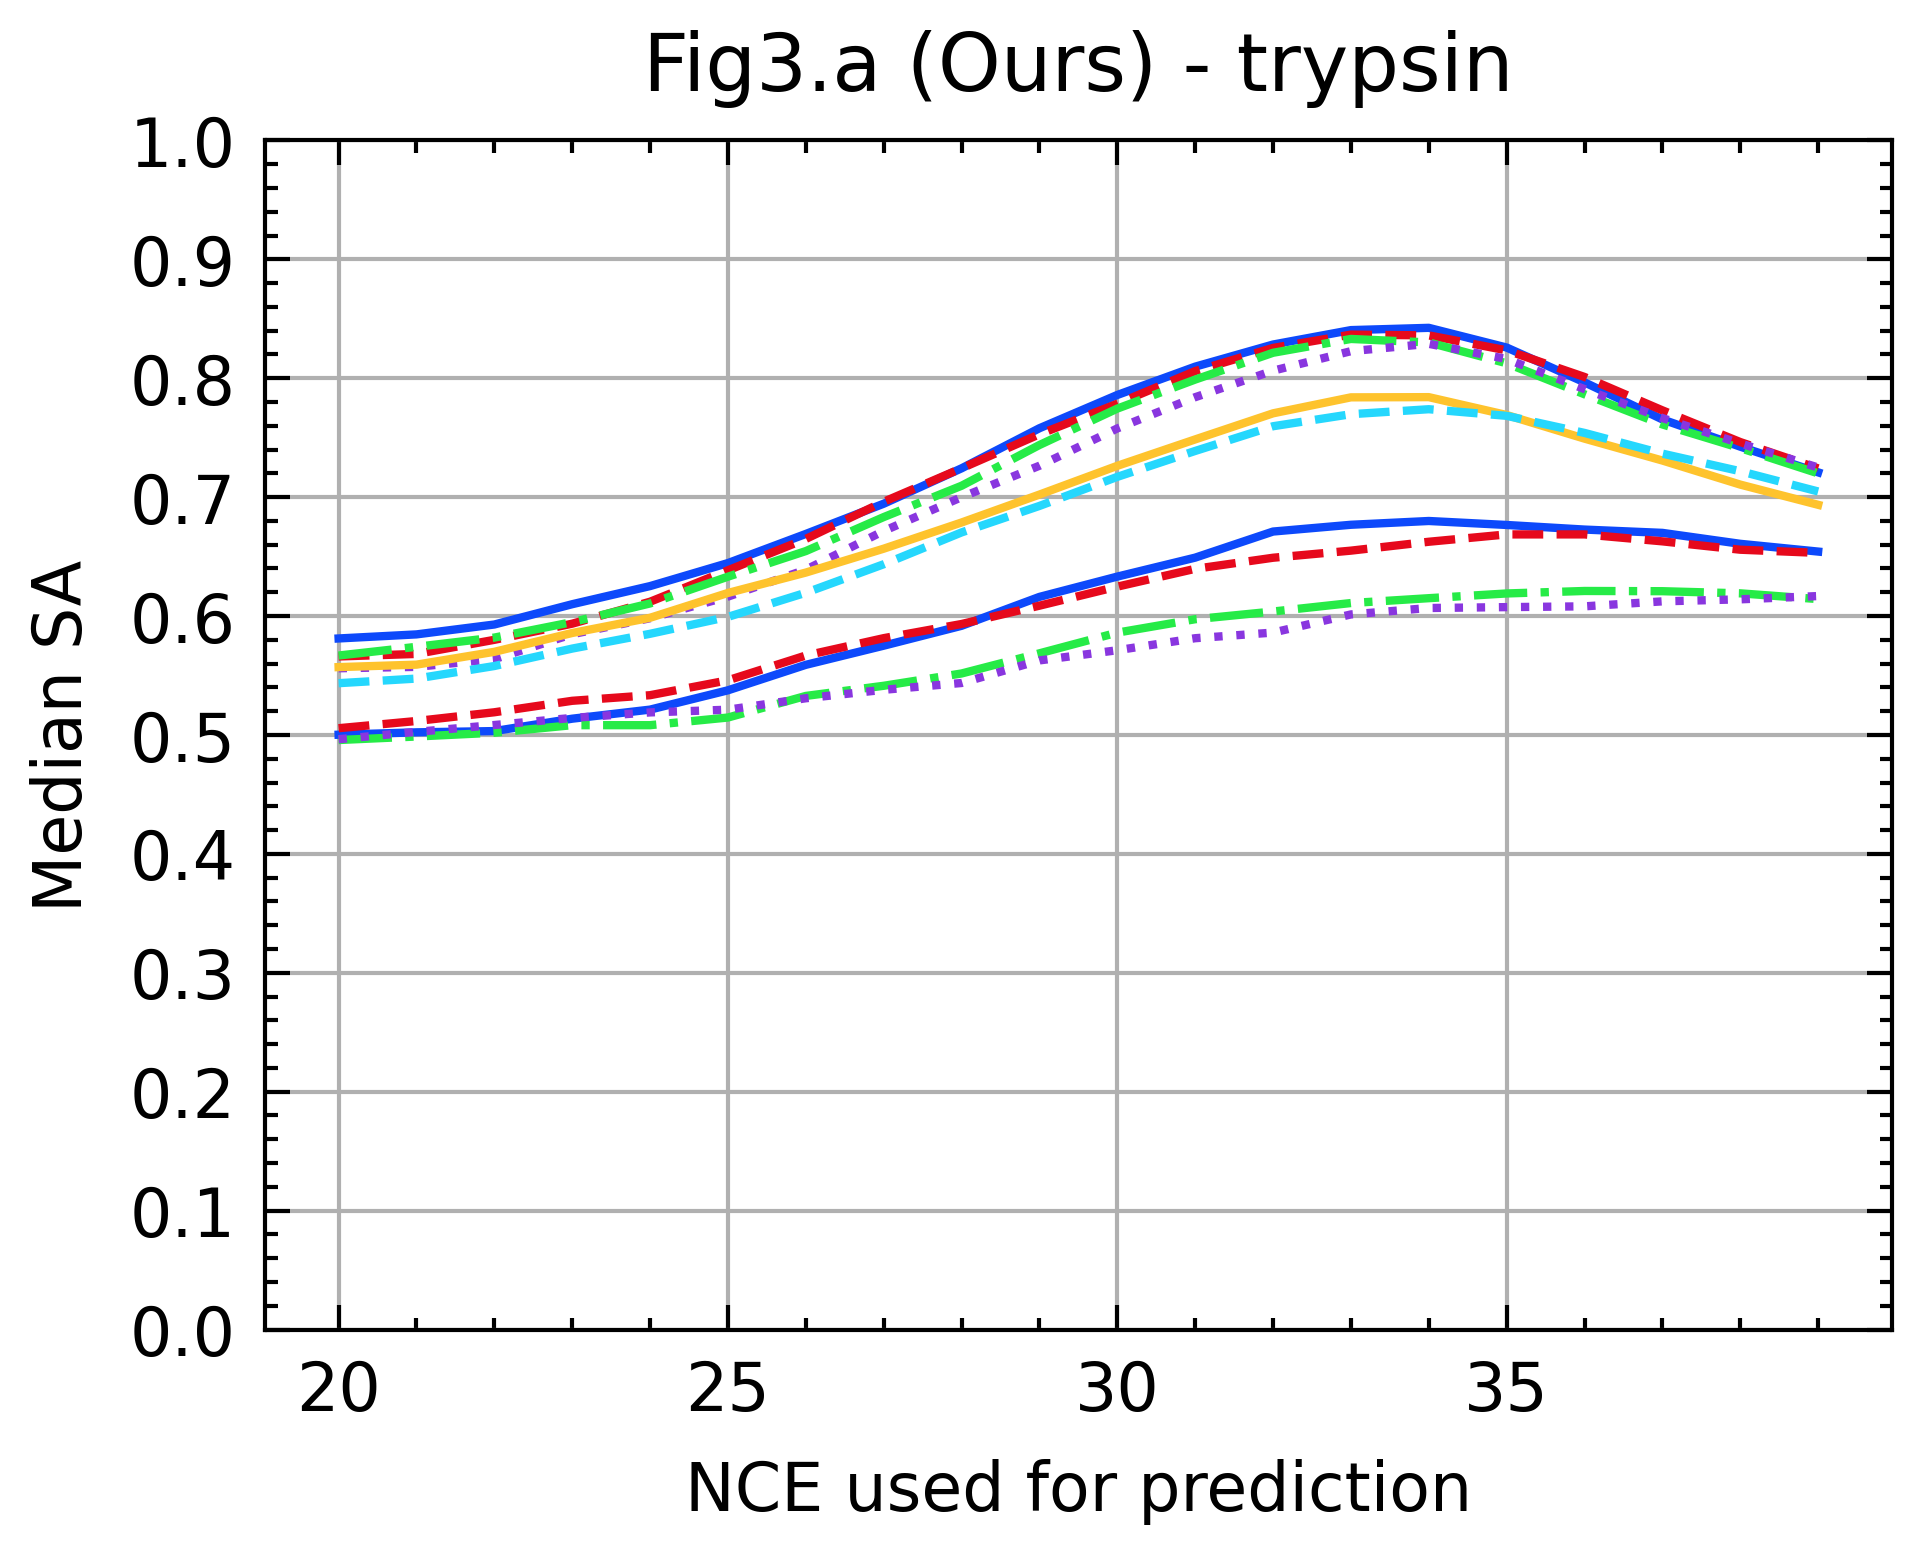

In [28]:
for name, p in add_steps.items():
    keys = sorted(list(p[1].keys()))
    plt.plot(keys, [p[1][k] for k in keys], label=name)
plt.xlabel("NCE used for prediction")
plt.ylabel("Median SA")
plt.title(f"Fig3.a (Ours) - {read_part}")
plt.yticks([0.1*i for i in range(0, 11)])
plt.grid()
# plt.legend()


In [ ]:
# for msms.txt picking
match_mq_raw = m_r

with open("top1000.txt", 'w') as f:
    for s in match_mq_raw:
        msms_inten = s[0][name.index('Intensities')].split(';')
        msms_mass =  s[0][name.index('Masses')].split(';')

        raw_inten = s[1][3].split(' ')
        raw_masses = s[1][2].split(' ')

        msms_flag = "\t".join([f"({float(k):6.1f};{float(v)/1000:8.1f})" for k,v in zip(msms_mass, msms_inten)])
        raw_flag  = "\t".join([f"({float(k):6.1f};{float(v)/1000:8.1f})" for k,v in zip(raw_masses, raw_inten)])
        f.write(
            f"{s[0][0]}:{s[0][1]}\n"
            f"  MSMS\t{msms_flag}\n"
            f"  RAW \t{raw_flag} \n"
        )


In [ ]:
matched_ions_pre = generate_matched_ions(m_r)
m_i = [bio_helper.match_all(i, 'yb') for i in matched_ions_pre]
m_i_2 = read_ions(msms_data, name)


100%|██████████| 1000/1000 [00:00<00:00, 588096.47it/s]


In [ ]:
with open("matched_ion.txt", 'w') as f:
    for i in range(len(m_r)):
        m1 = m_i[i]
        m2 = m_i_2[i]
        s = m_r[i]
        d1 = {k: (float(m), float(v)) for k, v, m in zip(*m1)}
        ions = []
        msms = []
        raws = []
        for k, v, m in zip(*m2):
            if k in d1:
                ions.append(k)
                msms.append((float(m), float(v)))
                raws.append(d1[k])
        ions_flag = "\t".join([f"{k:16}" for k in ions])
        msms_flag = "\t".join(f"({float(k):6.1f};{float(v)/1000:8.1f})" for k, v in msms)
        raws_flag = "\t".join(f"({float(k):6.1f};{float(v)/1000:8.1f})" for k, v in raws)
        f.write(
            f"{s[0][0]}:{s[0][1]}\n"
            f"  IONS\t{ions_flag}\n"
            f"  MSMS\t{msms_flag}\n"
            f"  RAW \t{raws_flag}\n"
        )


In [ ]:
import matplotlib.animation as animation

# fig, ax = plt.subplots()
# ax.set_xlim((0, 0.3))
# ax.set_ylim((0, 0.3))
# line = ax.scatter([0.5], [0.5])
for i, (m1, m2) in enumerate(zip(m_i[2:], m_i_2[2:])):
    x = []
    y = []
    d1 = {k:m for k, v, m in zip(*m1)}
    max1 = 1e-9
    max2 = 1e-9
    for k, v, m in zip(*m2):
        if k in d1:
            # print(f"{k:6}\t{d1[k]/max1:.3f}\t{float(v)/max2:.3f}")
            max1 += d1[k]
            max2 += float(m)
    for k, v, m in zip(*m2):
        if k in d1:
            # print(f"{k:6}\t{d1[k]/max1:.3f}\t{float(v)/max2:.3f}")
            x.append(d1[k]/max1)
            y.append(float(m)/max2)
plt.scatter(x, y)
print(len(x), len(y))
    # break
    # ax.clear()
    # break

# plt.scatter(x, y, s=3)
# plt.xlabel("Raw intensities")
# plt.ylabel("Maxquant")
# plt.show()
    # plt.clear()

In [ ]:
# reload(bio_helper)
# m_r = remove_intensities(m_r)
matched_ions_pre = generate_matched_ions(m_r)
m_i = [bio_helper.match_all(i, 'yb') for i in matched_ions_pre]
frag_msms = [bio_helper.reverse_annotation(*i[:2]) for i in m_i]
gt_frag = to_tensor(frag_msms)

m_i = read_ions(msms_data, name)
frag_msms = [bio_helper.reverse_annotation(*i[:2]) for i in m_i]
gt_frag2 = to_tensor(frag_msms)


def generate_from_msms(msms_data, nces=range(20, 40)):
    seqs = [i[name.index("Modified sequence")].strip("_") for i in msms_data]
    seqs = [bio_helper.peptide_to_inter(i) for i in seqs]
    seqs = np.concatenate(seqs)

    charges = [int(i[name.index("Charge")]) for i in msms_data]
    charges = [bio_helper.one_hot(i-1) for i in charges]
    charges = np.concatenate(charges)

    data_nce_cand = {}
    for nce in nces:
        data_nce_cand[nce] = [
            seqs,
            np.ones((len(seqs), ), dtype=int)*nce/100.0,
            charges
        ]
    return data_nce_cand


data_nce_cand = generate_from_msms(msms_data)
# data_nce_cand = read_from_nces(nce_dir)


100%|██████████| 1000/1000 [00:00<00:00, 314203.61it/s]


In [ ]:
import ms
from ms import model

run_model = model.PrositFrag()
run_model.load_state_dict(torch.load("../checkpoints/best/best_valid_irt_PrositFrag-1024.pth", map_location="cpu"))
run_model = run_model.eval()

# prosit_sa_lysc = get_nce_cal(run_model, data_nce_cand, gt_frag)
prosit_sa_trypsin1 = get_nce_cal(run_model, data_nce_cand, gt_frag)
# prosit_sa_trypsin2 = get_nce_cal(run_model, data_nce_cand, gt_frag2)
# prosit_sa_gluc = get_nce_cal(run_model, data_nce_cand, gt_frag)
# prosit_sa_chymo = get_nce_cal(run_model, data_nce_cand, gt_frag)


100%|██████████| 20/20 [00:00<00:00, 28.99it/s]


In [ ]:
for k, v in prosit_sa_trypsin1.items():
    print(k, torch.median(v).item(), torch.median(prosit_sa_trypsin2[k]).item())


In [ ]:
import ms
from ms import model

run_model = model.TransProBest()
run_model.load_state_dict(torch.load(
    "../checkpoints/best/best_valid_frag_TransPro-6-3-128-0.1-256-1048.pth", map_location="cpu"))
run_model = run_model.eval()

# trans_sa_lysc = get_nce_cal(run_model, data_nce_cand, gt_frag)
trans_sa_trypsin1 = get_nce_cal(run_model, data_nce_cand, gt_frag)
# trans_sa_trypsin2 = get_nce_all(run_model, data_nce_cand, gt_frag2)
# trans_sa_gluc = get_nce_cal(run_model, data_nce_cand, gt_frag)
# trans_sa_chymo = get_nce_cal(run_model, data_nce_cand, gt_frag)


100%|██████████| 20/20 [00:01<00:00, 11.78it/s]


In [ ]:
for k, v in trans_sa_trypsin1.items():
    print(k, torch.median(v).item(), torch.median(
        trans_sa_trypsin2[k]).item())


In [ ]:

# from tools import test_model_frag
# test_model_frag(run_model)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


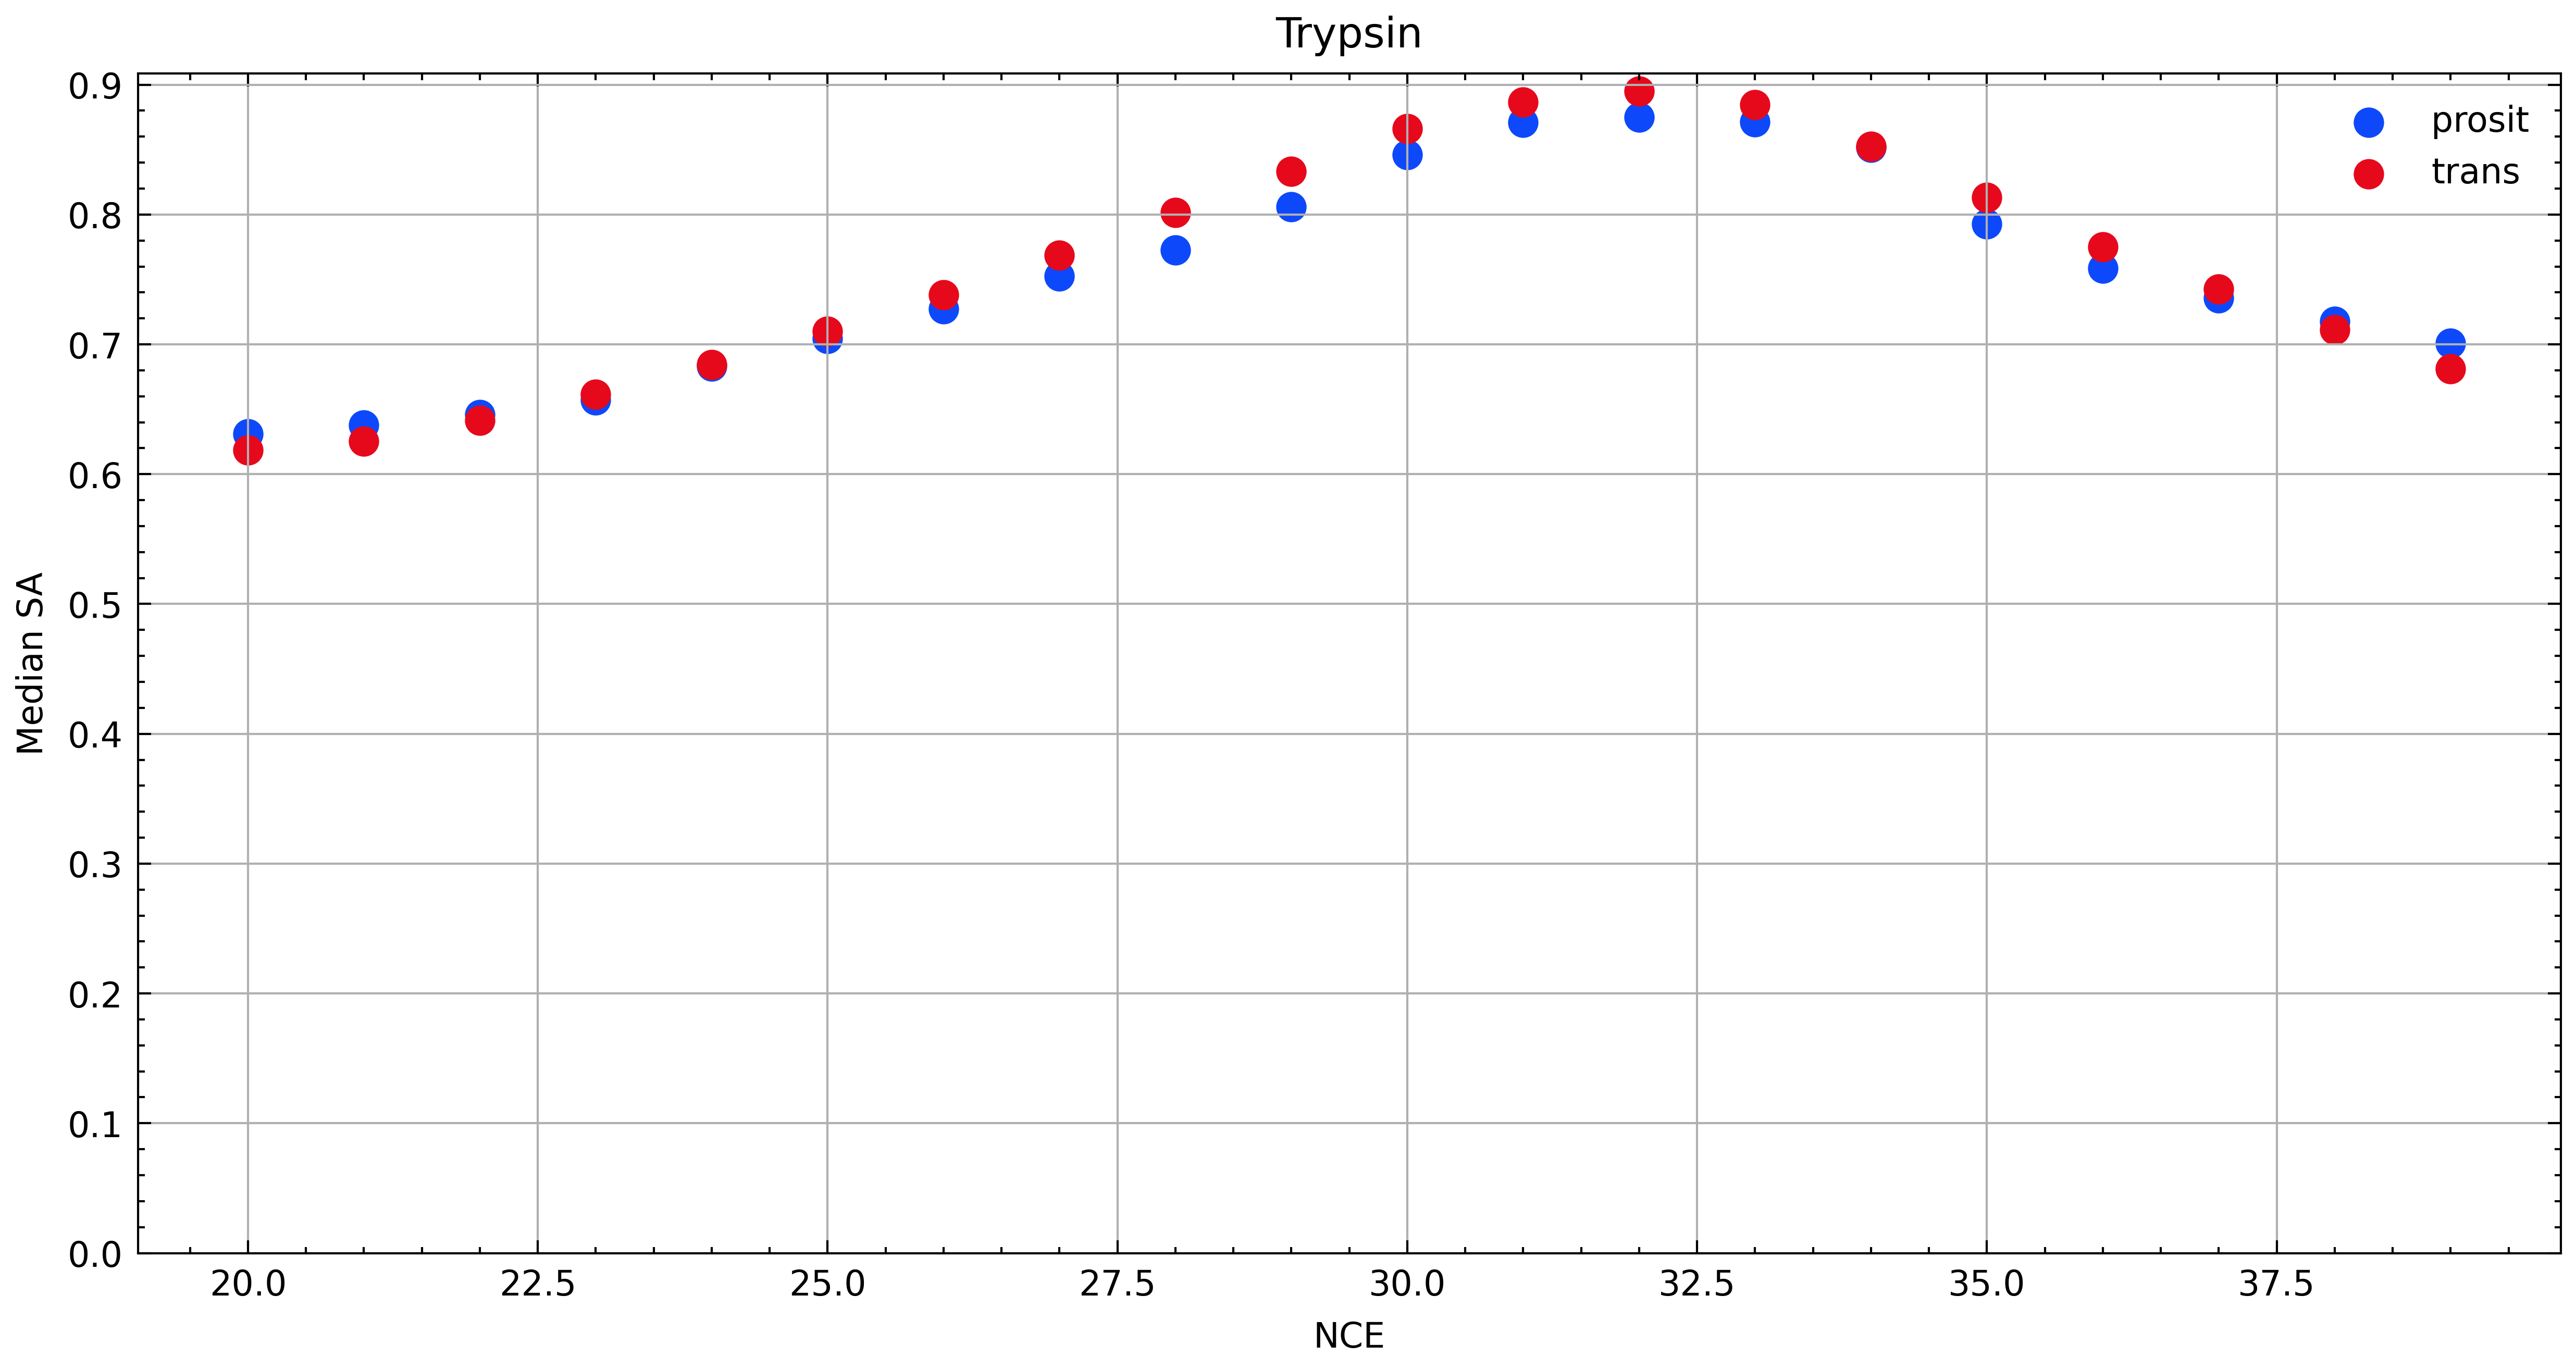

In [ ]:
# import dufte
reload(plt)
# plt.style.use(dufte.style)
plt.figure(figsize=(10, 5))
plt.scatter([k for k in prosit_sa_trypsin1.keys()], [
            v for v in prosit_sa_trypsin1.values()], label='prosit')
plt.scatter([k for k in trans_sa_trypsin1.keys()], [
            v for v in trans_sa_trypsin1.values()], label='trans')
plt.xlabel("NCE")
plt.ylabel("Median SA")
plt.title("Trypsin")
plt.yticks([0.1*i for i in range(0, 10)])
plt.grid()
plt.legend()
# print(x, y)

In [ ]:
print(trans_sa_trypsin)

{20: 0.35730210141300756, 21: 0.3589800757615824, 22: 0.36319990177443284, 23: 0.36731227721008963, 24: 0.36909003889387637, 25: 0.37787057715100025, 26: 0.3822084344686255, 27: 0.3890497581808754, 28: 0.389063806852856, 29: 0.39157915986299974, 30: 0.39232127694546326, 31: 0.39758092279953516, 32: 0.4001116404309961, 33: 0.39992731566576345, 34: 0.399319769842546, 35: 0.39432833572042436, 36: 0.3881685949898527, 37: 0.3818009880753833, 38: 0.3752141496222684, 39: 0.3658350382091803}


In [ ]:
print(trans_sa_trypsin)


{20: 0.3505553511842242, 21: 0.35165717366427307, 22: 0.35632905732384834, 23: 0.35861582136351655, 24: 0.3638034372910004, 25: 0.36924032453891176, 26: 0.3758193929770095, 27: 0.3804650529621514, 28: 0.38440753072152234, 29: 0.3848511439257022, 30: 0.38692372605040226, 31: 0.3923049212036168, 32: 0.39346332320671984, 33: 0.39422462253302926, 34: 0.3928553807136427, 35: 0.390480967665513, 36: 0.38237993594254993, 37: 0.3777939370551827, 38: 0.37070154063866156, 39: 0.3629094917953539}


Text(0, 0.5, 'Median SA')

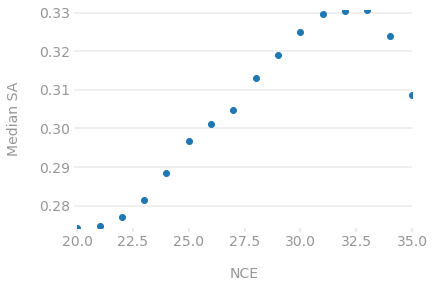

In [ ]:
name, msms_data = read_msms(
    "/data/prosit/test/fig3a/pick_msms.txt")
msms_data = filter_msms(name, msms_data)


m_i = read_ions(msms_data, name)
frag_msms = [bio_helper.reverse_annotation(*i) for i in m_i]
gt_frag = to_tensor(frag_msms)


def read_from_prosit(nce_dir="/data/prosit/test/fig3a/results"):
    data_nce_cand = {}
    for name in os.listdir(nce_dir):
        if not name.endswith("txt"):
            continue
        with open(os.path.join(nce_dir, name)) as f:
            data_nce = []
            for i, line in enumerate(f):
                if not i:
                    continue
                data_nce.append(line.strip().split())
            frag_nce = read_prosit_ions(data_nce)
            frag_msms = [bio_helper.reverse_annotation(*i) for i in frag_nce]
        data_nce_cand[name] = to_tensor(frag_msms)
    return data_nce_cand


data_nce_cand = read_from_prosit()
all_sa = {}
for k, v in data_nce_cand.items():
    nce = int(k[:-4])
    all_sa[nce] = helper.median_spectral_angle(gt_frag, v)


import matplotlib.pyplot as plt

x = []
y = []
for k, v in all_sa.items():
    x.append(k)
    y.append(v)
plt.scatter(x, y)
plt.xlabel("NCE")
plt.ylabel("Median SA")


27.txt
31.txt
20.txt
22.txt
23.txt
32.txt
30.txt
28.txt
26.txt
24.txt
21.txt
34.txt
35.txt
29.txt
33.txt
25.txt


Text(0, 0.5, 'Median SA')

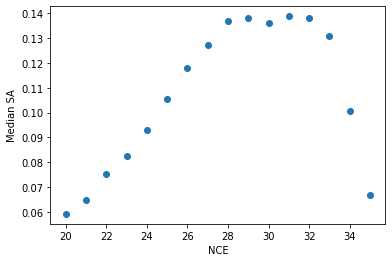